# **Forest Fire Model**

In [1]:
""" Drossel-Schwabl Forest Fire Model — with Fire Size & Duration Tracking """

import matplotlib.pyplot as plt
import numpy as np
from numpy import uint8
from IPython.display import clear_output
plt.rcParams.update({'font.size': 14})
from numba import njit


@njit
def update(
    landscape, tree_growth_rate, lightning_strike_rate, update_plot_wait,
    tree_percent_record
):
    Lx, Ly = landscape.shape
    p = tree_growth_rate / (Lx * Ly)
    f = lightning_strike_rate / (Lx * Ly)

    tree_site = uint8(0)
    empty_site = uint8(1)
    burning_site = uint8(2)

    for _ in range(update_plot_wait):
        new_burning_sites = []
        new_empty_sites = []
        new_tree_sites = []
        num_trees = 0
        neighbors = np.full((4,2), 0)

        for i in range(Lx):
            for j in range(Ly):
                site_status = landscape[i, j]
                if site_status == burning_site:
                    neighbors[:] = np.array([
                        [i-1, j], [i+1, j], [i, j-1], [i, j+1]
                    ])
                    for ni, nj in neighbors:
                        if 0 <= ni < Lx and 0 <= nj < Ly:
                            if landscape[ni, nj] == tree_site:
                                new_burning_sites.append([ni, nj])
                                num_trees -= 1
                    new_empty_sites.append([i, j])
                elif site_status == tree_site:
                    if np.random.random() < f:
                        new_burning_sites.append([i, j])
                    else:
                        num_trees += 1
                else:
                    if np.random.random() < p:
                        new_tree_sites.append([i, j])
                        num_trees += 1

        for i, j in new_empty_sites:
            landscape[i, j] = empty_site
        for i, j in new_burning_sites:
            landscape[i, j] = burning_site
        for i, j in new_tree_sites:
            landscape[i, j] = tree_site

        tree_percent = num_trees * 100 / (Lx * Ly)
        tree_percent_record = np.append(tree_percent_record, tree_percent)

    return tree_percent_record


def landscape_to_colors(landscape):
    Lx, Ly = landscape.shape
    color_matrix = np.empty((Lx, Ly, 3))
    tree_site, empty_site, burning_site = (uint8(i) for i in range(3))
    color_matrix[landscape == empty_site] = [0., 0., 0.]    # empty → blue
    color_matrix[landscape == burning_site] = [1., 0., 0.]  # burning → red
    color_matrix[landscape == tree_site] = [0., 1., 0.]     # tree → green
    return color_matrix


def setup_plot():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.tight_layout(pad=2.0)
    ax1.axis('off')
    ax2.set_xlabel('time')
    ax2.set_ylabel('% trees')
    ax2.set_ylim(0, 100)
    return fig, ax1, ax2


def update_plot(landscape, tree_percent, t, pause_time=0.001):
    fig, ax1, ax2 = setup_plot()
    ax1.imshow(landscape_to_colors(landscape))
    ax2.plot(np.arange(len(tree_percent)), tree_percent, c='blue')
    avg_tree_pct = round(np.mean(tree_percent))
    ax2.set_title('Average tree coverage: ' + str(avg_tree_pct) + '%')
    clear_output(wait=True)
    fig.canvas.draw()
    plt.pause(pause_time)


def has_tree_fraction_stabilized(tree_percent_record, window=100, threshold=0.01):
    if len(tree_percent_record) < window:
        return False
    recent = tree_percent_record[-window:]
    return np.max(recent) - np.min(recent) < threshold


def run_simulation(
    Lx=100,
    Ly=100,
    start_tree_percent=50,
    start_fire=1,  # 0 = left side, 1 = center
    tree_growth_rate=1000,
    lightning_strike_rate=2,
    update_plot_wait=1,
    max_steps=100000,
    fire_radius=3,
    stabilize_check_window=100,
    stabilize_threshold=0.001
):
    tree_fraction = start_tree_percent / 100.
    tree_site, empty_site, burning_site = (uint8(i) for i in range(3))
    landscape = np.random.choice(
        [tree_site, empty_site], p=[tree_fraction, 1 - tree_fraction], size=(Lx, Ly)
    )

    if start_fire == 0:
        landscape[:, 0] = burning_site
    elif start_fire == 1:
        center_x, center_y = Lx // 2, Ly // 2
        for i in range(center_x - fire_radius, center_x + fire_radius + 1):
            for j in range(center_y - fire_radius, center_y + fire_radius + 1):
                if 0 <= i < Lx and 0 <= j < Ly:
                    if landscape[i, j] == tree_site:
                        landscape[i, j] = burning_site

    time = 0
    tree_percent = 100 * np.sum(landscape == 0) / (Lx * Ly)
    tree_percent_record = np.array([tree_percent])

    fire_sizes = []
    fire_durations = []
    fire_active = False
    current_fire_size = 0
    current_fire_duration = 0

    for step in range(0, max_steps, update_plot_wait):
        update_plot(landscape, tree_percent_record, time)

        # Track burning cluster
        current_burning = np.sum(landscape == burning_site)
        if current_burning > 0:
            if not fire_active:
                fire_active = True
                current_fire_size = 0
                current_fire_duration = 0
            current_fire_size += current_burning
            current_fire_duration += 1
        elif fire_active:
            fire_sizes.append(current_fire_size)
            fire_durations.append(current_fire_duration)
            fire_active = False

        # Update landscape
        tree_percent_record = update(
            landscape,
            tree_growth_rate,
            lightning_strike_rate,
            update_plot_wait,
            tree_percent_record
        )
        time += update_plot_wait

        # Stop if stabilized
        if has_tree_fraction_stabilized(tree_percent_record, stabilize_check_window, stabilize_threshold):
            print(f"\n✅ Tree fraction stabilized — stopping early at step {step}.")
            break

    # Summary
    print("\n🔥 Simulation Complete")
    print(f"Total Fires: {len(fire_sizes)}")
    if fire_sizes:
        print(f"Average Fire Size: {np.mean(fire_sizes):.2f}")
        print(f"Average Fire Duration: {np.mean(fire_durations):.2f}")

    return tree_percent_record, fire_sizes, fire_durations

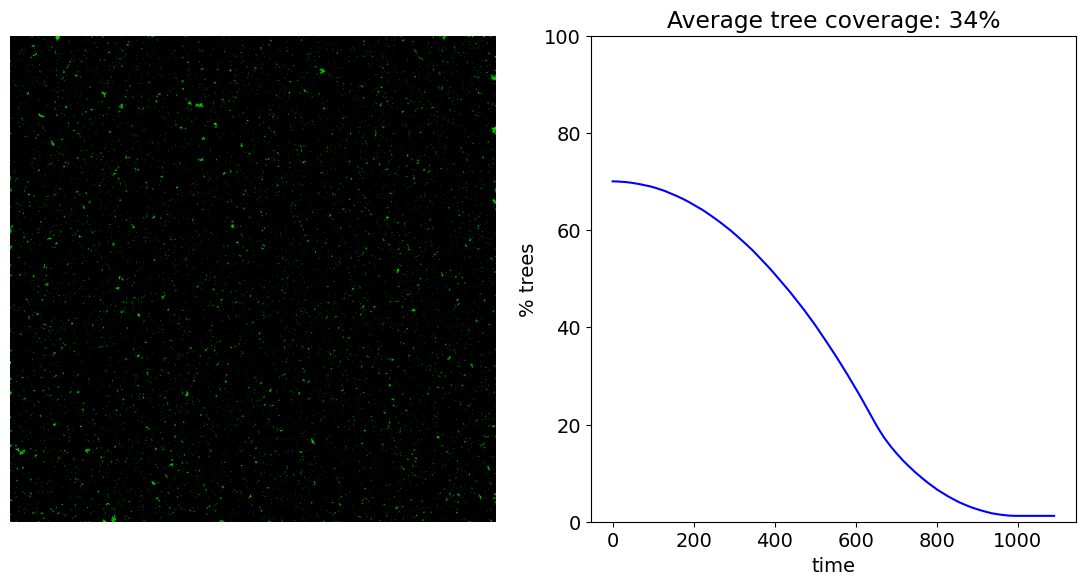


✅ Tree fraction stabilized — stopping early at step 1090.

🔥 Simulation Complete
Total Fires: 1
Average Fire Size: 68666.00
Average Fire Duration: 101.00


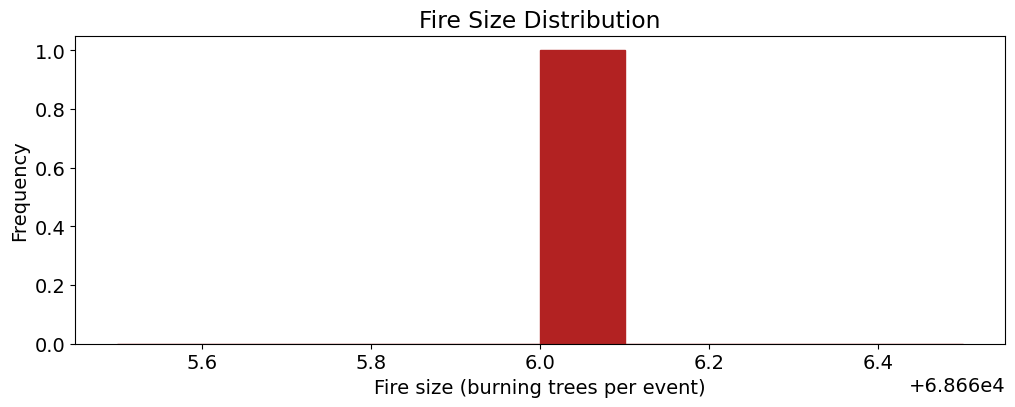

In [2]:
# Run the model
# Run this cell to control the simulation
tree_record, fire_sizes, fire_durations = run_simulation(
    Lx=1000,                     # number of sites in x direction
    Ly=1000,                     # number of sites in y direction
    start_tree_percent=70,     # initial percentage of sites with trees
    start_fire=1,              # 0 = left edge, 1 = center
    tree_growth_rate=0,        # number of trees growing per timestep
    lightning_strike_rate=0,   # number of lightning strikes per timestep
    update_plot_wait=10,       # update plot every this many timesteps
    max_steps=100000           # max steps before stopping
)


# Plot fire size histogram
plt.figure(figsize=(12, 4))
plt.hist(fire_sizes, bins=10, color='firebrick', edgecolor='firebrick')
plt.xlabel("Fire size (burning trees per event)")
plt.ylabel("Frequency")
plt.title("Fire Size Distribution")
plt.show()


In [3]:
import ipywidgets as widgets
from IPython.display import display

ui = widgets.interactive(run_simulation,
    Lx=widgets.IntSlider(min=50, max=200, step=10, value=100),
    Ly=widgets.IntSlider(min=50, max=200, step=10, value=100),
    start_tree_percent=widgets.IntSlider(min=0, max=100, step=5, value=50),
    start_fire=widgets.Dropdown(options=[("Left", 0), ("Center", 1)], value=1),
    tree_growth_rate=widgets.IntSlider(min=0, max=2000, step=50, value=0),
    lightning_strike_rate=widgets.IntSlider(min=0, max=100, step=1, value=0),
    update_plot_wait=widgets.IntSlider(min=1, max=50, step=1, value=10),
    max_steps=widgets.IntText(value=100000)
)

display(ui)


interactive(children=(IntSlider(value=100, description='Lx', max=200, min=50, step=10), IntSlider(value=100, d…